## Here, we used new training data generated using a new dispersion that has been updated with the scale factor found by previous models


In [1]:
#Load packages#
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

In [16]:
#Load the training data


peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

col_names = ['deltaI', 'deltaR']+ peak_names + locs_names + width_names + prom_names

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
data_spec = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData062218_v8_specPoints.csv', header = None, names = ['deltaI', 'deltaR'] + energy_names)
energy_downsampled = linspace(-400, 500, 151).astype(int)
energy_downsampled_names = ['E_%i_mV' % item for item in list(energy_downsampled.T)]
data_peaks = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData062218_v8_peakinfo.csv', header = None, names = col_names)
data_spec = data_spec[energy_downsampled_names]
data_spec.head()
data_peaks.head()
data = data_peaks.join(data_spec)

X = data.drop(['deltaI', 'deltaR'], axis = 1)
Y = data[['deltaI', 'deltaR']]

ts1 = 0.3
rs1 = 42

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1 )
#X_train.head()
data.head()

,deltaI,deltaR,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,...,E_446_mV,E_452_mV,E_458_mV,E_464_mV,E_470_mV,E_476_mV,E_482_mV,E_488_mV,E_494_mV,E_500_mV
0,0.81472,-0.147980,5.5515,3.6143,2.7947,2.0804,-0.346,-0.220,-0.038,0.194,...,1.27720,1.4072,1.5226,1.5989,1.6173,1.5748,1.4851,1.37140,1.25390,1.14680
1,0.12699,-0.136070,3.0310,2.1081,1.6693,1.3521,-0.354,-0.238,-0.064,0.162,...,1.16650,1.1489,1.1286,1.1078,1.0879,1.0704,1.0560,1.04540,1.03810,1.03410
2,0.63236,-1.417600,9.8176,6.1802,4.6570,3.3744,-0.344,-0.218,-0.034,0.198,...,0.98927,1.2298,1.5585,1.9563,2.3251,2.4798,2.3197,1.96040,1.58070,1.26810
3,0.27850,-0.711760,12.6330,8.4448,6.1732,4.2781,-0.348,-0.224,-0.046,0.182,...,2.41280,2.9214,2.8922,2.3656,1.7679,1.3141,1.0084,0.81111,0.68261,0.60238
4,0.95751,-0.055153,5.6213,3.6863,2.8611,2.1287,-0.346,-0.220,-0.038,0.196,...,1.22360,1.3614,1.4951,1.5989,1.6481,1.6302,1.5529,1.43910,1.31340,1.19400


## Using the Best Models on the Hexagon Data

### Statsmodels

 
RMSE on test data: 0.10046145705317754 for  Delta I
R^2 Score on test data: 0.879958599232926 for Delta I
 
RMSE on test data: 0.09976971459526798 for  Delta R
R^2 Score on test data: 0.9515193634546779 for Delta R
 
RMSE on test data: 0.09976971459526798 for  Delta R Zoomed In
R^2 Score on test data: 0.9515193634546779 for Delta R Zoomed In
The average residual for predict: 0.0295
Residual is this percent of predict range 0.562 %
The average residual for predict: 0.029
Residual is this percent of predict range 0.528 %


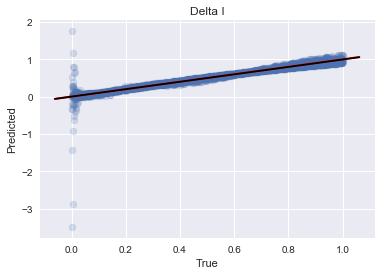

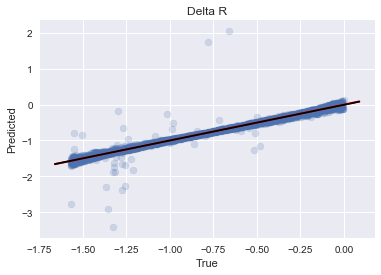

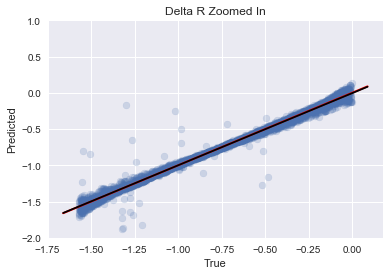

In [3]:
#Initialize and fit OLS model for deltaI 
model_OLS_I = sm.OLS(Y_train['deltaI'], X_train)
model_OLS_R = sm.OLS(Y_train['deltaR'], X_train)

results_OLS_I = model_OLS_I.fit()
results_OLS_R = model_OLS_R.fit()

#Make predictions on testing data
predictions_OLS_I = results_OLS_I.predict(X_test) # make the predictions by the model
predictions_OLS_R = results_OLS_R.predict(X_test)

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y_test['deltaI'], predictions_OLS_I,'Delta I')
#ylim([-1,5])
plotSummary(Y_test['deltaR'], predictions_OLS_R, 'Delta R')
plotSummary(Y_test['deltaR'], predictions_OLS_R, 'Delta R Zoomed In')
ylim([-2,1])

myResiduals(Y_test['deltaI'], predictions_OLS_I)
myResiduals(Y_test['deltaR'], predictions_OLS_R)


### Decision Tree

 
RMSE on test data: 0.01074486536468755 for  deltaI Depth 60
R^2 Score on test data: 0.9986267991445568 for deltaI Depth 60
 
RMSE on test data: 0.010614052637768403 for  deltaR Depth 60
R^2 Score on test data: 0.9994513020623375 for deltaR Depth 60
 
Regression - Decision Tree -  Score:  0.9992117663530025 , using max depth of 30
 
Cross Validation Scores for regressor with max depth of  30  :  [0.9990316  0.99913288 0.9990816  0.9991231  0.99910671 0.99912416
 0.99906872 0.99911768 0.99910464 0.99909773]


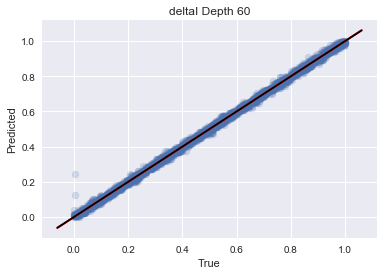

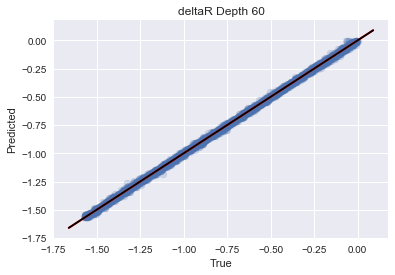

In [4]:
#Initialize the model
rs = 42
regr_DT = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT.fit(X_train, Y_train)

#Print the coefficients or importances

data1 = pd.DataFrame(regr_DT.feature_importances_.T, columns = ['Regr - DT']) 

data1.index = X_train.columns

#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
y_pred_DT = regr_DT.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], y_pred_DT[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], y_pred_DT[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])


print(' ')

#Trying to understand the scoring
print('Regression - Decision Tree -  Score: ', regr_DT.score(X_test,Y_test),', using max depth of 30')
print(' ')
regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print( 'Cross Validation Scores for regressor with max depth of ', regressor.max_depth, ' : ', cross_val_score(regressor, X, Y, cv=10))

## Random Forest


Score - Random Forest: 0.9999174999178797 for delta I/R 10
 
RMSE on test data: 0.0034011988211584045 for  deltaI 10
R^2 Score on test data: 0.9998624070604929 for deltaI 10
 
RMSE on test data: 0.0035081179830482386 for  deltaR 10
R^2 Score on test data: 0.9999400596553881 for deltaR 10


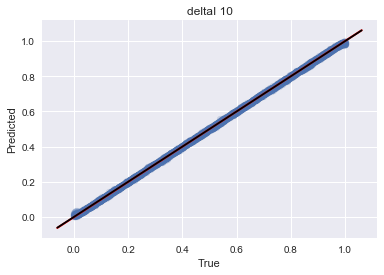

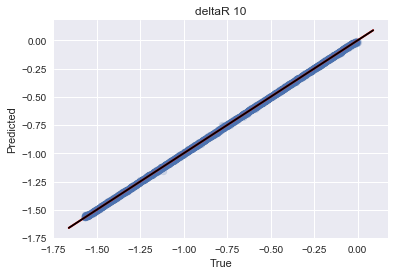

In [5]:
rs = 42
regr_RF = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF = regr_RF.fit(X_train, Y_train)

predict_RF = model_RF.predict(X_test)


importance_RF_10 = pd.Series(model_RF.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF.score(X_test, Y_test), 'for delta I/R 10')

plotSummary(Y_test['deltaI'], predict_RF[:,0], 'deltaI 10')
plotSummary(Y_test['deltaR'], predict_RF[:,1], 'deltaR 10')


## Independent Random Forests


Score - Random Forest: 0.999962456169582 for delta I/R 10
 
RMSE on test data: 0.0027764116810346617 for  deltaI 10
R^2 Score on test data: 0.999962456169582 for deltaI 10
 
RMSE on test data: 0.0024114836792268 for  deltaR 10
R^2 Score on test data: 0.9999308327095292 for deltaR 10


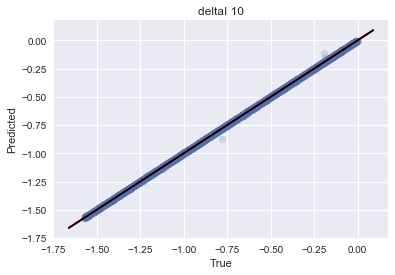

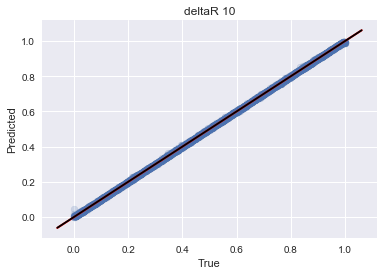

In [6]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr = regr_RF2_dr.fit(X_train, Y_train['deltaR'])
model_RF2_di = regr_RF2_di.fit(X_train, Y_train['deltaI'])

predict_RF2_dr = model_RF2_dr.predict(X_test)
predict_RF2_di = model_RF2_di.predict(X_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr.score(X_test, Y_test['deltaR']), 'for delta I/R 10')

plotSummary(Y_test['deltaR'], predict_RF2_dr, 'deltaI 10')
plotSummary(Y_test['deltaI'], predict_RF2_di, 'deltaR 10')


## AdaBoost Random Forest

 
RMSE on test data: 0.0024160477787364674 for  AdaBoost Delta I
R^2 Score on test data: 0.9999305706425358 for AdaBoost Delta I
 
RMSE on test data: 0.002323332782269208 for  AdaBoost Delta R
R^2 Score on test data: 0.999973709811836 for AdaBoost Delta R
Delta I AdaBoost Score: 0.9999305706425357
Delta R AdaBoost Score: 0.999973709811836


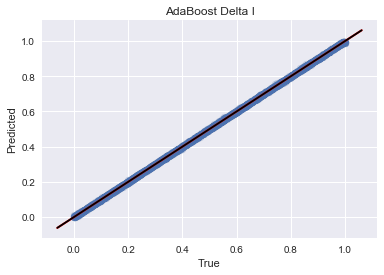

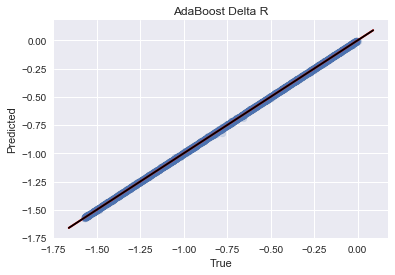

In [7]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_ABR = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB = regr_AB.fit(X_train, Y_train['deltaI'])
model_AB_R = regr_ABR.fit(X_train, Y_train['deltaR'])

y_pred_AB1 = model_AB.predict(X_test)
y_pred_AB1_R = model_AB_R.predict(X_test)


plotSummary(Y_test['deltaI'], y_pred_AB1, 'AdaBoost Delta I')
plotSummary(Y_test['deltaR'], y_pred_AB1_R, 'AdaBoost Delta R')

print('Delta I AdaBoost Score:', model_AB.score(X_test, Y_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_R.score(X_test, Y_test['deltaR']))


## Gradient Boosting Random Forest

In [8]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


regr_GB = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GBR = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)



In [9]:
model_GB = regr_GB.fit(X_train, Y_train['deltaI'])


In [10]:
model_GB_R = regr_GBR.fit(X_train, Y_train['deltaR'])


 
RMSE on test data: 0.01298711941183429 for  GradientBoost Delta I
R^2 Score on test data: 0.9979938759858809 for GradientBoost Delta I
 
RMSE on test data: 0.019506611773022493 for  GradientBoost Delta R
R^2 Score on test data: 0.9981467477550497 for GradientBoost Delta R
Delta I Gradient Boost Score: 0.9979938759858809
Delta R Gradient Boost Score: 0.9981467477550497


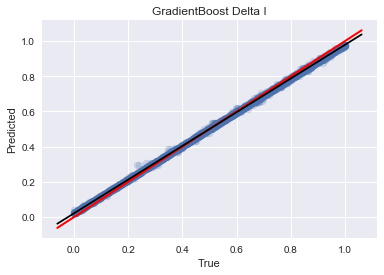

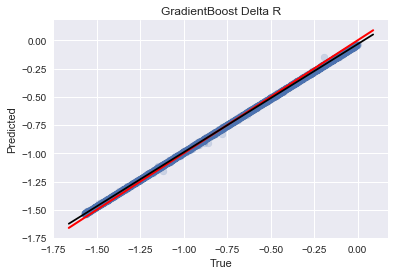

In [11]:
y_pred_GB1 = model_GB.predict(X_test)
y_pred_GB1_R = model_GB_R.predict(X_test)

plotSummary(Y_test['deltaI'], y_pred_GB1, 'GradientBoost Delta I')
plotSummary(Y_test['deltaR'], y_pred_GB1_R, 'GradientBoost Delta R')

print('Delta I Gradient Boost Score:', model_GB.score(X_test, Y_test['deltaI']))
print('Delta R Gradient Boost Score:', model_GB_R.score(X_test, Y_test['deltaR']))


## Testing the Models on the Experimental Data



In [12]:
# Load the experimental data
col_names_exp = peak_names + locs_names + width_names + prom_names
# Manipulate the experimental data 
energy_exp = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names_exp = ['E_%i_mV' % item for item in list(energy_exp.T[0])]
data_spec_exp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_specPoints.csv', header = None, names = energy_names_exp)
energy_downsampled_exp = linspace(-400, 500,151).astype(int)
energy_downsampled_names_exp = ['E_%i_mV' % item for item in list(energy_downsampled_exp.T)]
data_peaks_exp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_peakinfo.csv', header = None, names = col_names_exp)
data_spec_exp = data_spec_exp[energy_downsampled_names_exp]
exp_data = data_peaks_exp.join(data_spec_exp)
exp_data.head()

,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,...,E_446_mV,E_452_mV,E_458_mV,E_464_mV,E_470_mV,E_476_mV,E_482_mV,E_488_mV,E_494_mV,E_500_mV
0,1.7917,1.9262,1.8662,1.4495,-0.362,-0.242,-0.074,0.134,0.026521,0.032045,...,0.98307,0.97924,1.0027,1.0154,1.0104,1.0439,1.0453,0.98221,0.98729,0.97779


In [13]:
pred_phase_OLS_R = results_OLS_R.predict(exp_data)
pred_phase_OLS_I = results_OLS_I.predict(exp_data)

pred_phase_DT = np.append(regr_DT.predict(exp_data),r2_score(Y_test['deltaI'], y_pred_DT[:,0])).reshape(3,1).T
pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['deltaR'], y_pred_DT[:,1])).reshape(4,1).T
#pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['scale_factor'], y_pred_DT[:,2]))

pred_phase_RF = regr_RF.predict(exp_data)

pred_phase_AB_R = model_AB_R.predict(exp_data)
pred_phase_AB_I = model_AB.predict(exp_data)

pred_phase_GB_I = model_GB.predict(exp_data)
pred_phase_GB_R = model_GB_R.predict(exp_data)

pred_phase_IRF_di = model_RF2_di.predict(exp_data)
pred_phase_IRF_dr = model_RF2_dr.predict(exp_data)

predictedPhases = pd.DataFrame(pred_phase_DT, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree'])

predictedPhases.loc['OLS'] = (pred_phase_OLS_I[0], pred_phase_OLS_R[0], r2_score(Y_test['deltaI'],predictions_OLS_I ), r2_score(Y_test['deltaR'],predictions_OLS_R ))
predictedPhases.loc['Random Forest'] = (pred_phase_RF[0,0], pred_phase_RF[0,1], r2_score(Y_test['deltaI'], predict_RF[:,0]), r2_score(Y_test['deltaR'], predict_RF[:,1]))

predictedPhases.loc['AdaBoost'] = (pred_phase_AB_I[0], pred_phase_AB_R[0],r2_score(Y_test['deltaI'], y_pred_AB1), r2_score(Y_test['deltaR'], y_pred_AB1_R))
predictedPhases.loc['Gradient Boosting'] = (pred_phase_GB_I[0], pred_phase_GB_R[0],  r2_score(Y_test['deltaI'], y_pred_GB1), r2_score(Y_test['deltaR'], y_pred_GB1_R))
predictedPhases.loc['Independent Random Forests'] = (pred_phase_IRF_di[0], pred_phase_IRF_dr[0],  r2_score(Y_test['deltaI'], predict_RF2_di ), r2_score(Y_test['deltaR'], predict_RF2_dr))

predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree,0.036695,-0.068435,0.998627,0.999451
OLS,90.118657,-80.394987,0.879959,0.951519
Random Forest,0.048205,-0.099489,0.999862,0.999940
AdaBoost,0.026649,-0.171510,0.999931,0.999974
Gradient Boosting,0.067100,-0.199007,0.997994,0.998147
Independent Random Forests,0.038327,-0.173302,0.999931,0.999962


In [14]:
#Since this prediction has a score less than 0.99, we will exclude it. 
GoodPredictedPhases = predictedPhases.drop(['OLS'], axis = 0)

deltaI_1 = (GoodPredictedPhases['deltaI']*GoodPredictedPhases['deltaI score']).mean()
deltaR_1 = (GoodPredictedPhases['deltaR']*GoodPredictedPhases['deltaR score']).mean()

print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')


The weighted average for the predicted phase is:  -0.14226386999033572  +  0.04335603800023071 *i
